In [1]:
import TCGAData, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import seaborn as sns
import tqdm

root = "/mnt/home/sgolkar/projects/cancer-net/data/brain"
files = "/mnt/home/sgolkar/projects/cancer-net/data/brain/samples.txt"
label_mapping = ["LGG", "GBM"]
dataset = TCGAData.TCGADataset(
    root=root,
    files=files,
    label_mapping=label_mapping,
    gene_graph="brain.geneSymbol.gz",
)

In [2]:
gene_dict = {
    el: i
    for i, el in enumerate(
        set([item for sublist in dataset.data.node_id for item in sublist])
    )
}
num_genes = len(gene_dict)

Xencoding = np.zeros((dataset.num_samples, num_genes, 128))
Xmutated = np.zeros((dataset.num_samples, num_genes))
Xmutnorm = np.zeros((dataset.num_samples, num_genes))
Xnummut = np.zeros((dataset.num_samples, 1))
Xnummutv2 = np.zeros((dataset.num_samples, 1))

for sample_num in range(dataset.num_samples):
    sample_data = dataset.get(sample_num)
    Xnummut[sample_num, 0] = len(sample_data.node_id)
    for encoding, sample_gene in zip(sample_data.x, sample_data.node_id):
        Xencoding[sample_num, gene_dict[sample_gene]] = encoding
        Xmutated[sample_num, gene_dict[sample_gene]] = 1
        Xmutnorm[sample_num, gene_dict[sample_gene]] = np.linalg.norm(encoding)
    Xnummutv2[sample_num, 0] = (Xmutnorm[sample_num] != 0).sum()

Xmutatedv2 = (Xmutnorm != 0).astype(float)
Xencoding_flat = Xencoding.reshape(len(Xencoding), -1)

In [3]:
method_dict = {
    "LR on num_mut": {"data": Xnummut, "fitter": LogisticRegression,},
    "LR on num_mutv2": {"data": Xnummutv2, "fitter": LogisticRegression,},
    "LR on mut_onehot": {"data": Xmutated, "fitter": LogisticRegression,},
    "LR on mut_onehotv2": {"data": Xmutatedv2, "fitter": LogisticRegression,},
    "LR on mut_size": {"data": Xmutnorm, "fitter": LogisticRegression,},
    "LR on full_encoding": {"data": Xencoding_flat, "fitter": LogisticRegression,},
}
results = {"method": [], "split": [], "accuracy": []}

for valid_seed in tqdm.tqdm(range(20), desc="iterations"):

    dataset.set_valid_seed(valid_seed)

    y_test = dataset.data.y[dataset.test_idx]
    y_train = dataset.data.y[dataset.train_idx]
    y_valid = dataset.data.y[dataset.valid_idx]

    for method_key, method_val in method_dict.items():

        X = method_val["data"]
        fitter = method_val["fitter"]()
        fitter.fit(X[dataset.train_idx], dataset.data.y[dataset.train_idx])

        for split, idx in zip(
            ["train", "valid", "test"],
            [dataset.train_idx, dataset.valid_idx, dataset.test_idx],
        ):
            results["method"].append(method_key)

            results["split"].append(split)

            X_split = X[idx]
            Y_split = dataset.data.y[idx]
            results["accuracy"].append(fitter.score(X_split, Y_split))

iterations: 100%|██████████| 20/20 [11:58<00:00, 35.92s/it]


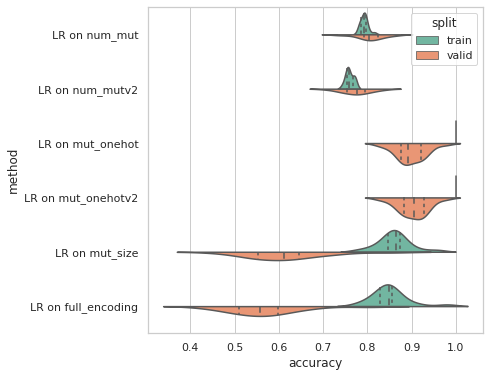

In [18]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(6, 6))
sns.violinplot(
    data=pd.DataFrame(results),
    y="method",
    hue="split",
    x="accuracy",
    hue_order=["train", "valid"],
    split=True,
    inner="quartile",
    palette="Set2",
);

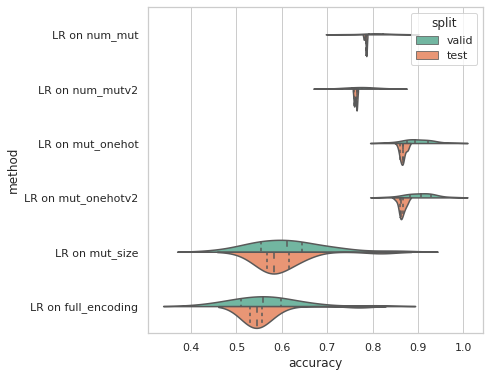

In [19]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(6, 6))
sns.violinplot(
    data=pd.DataFrame(results),
    y="method",
    hue="split",
    x="accuracy",
    hue_order=["valid", "test"],
    split=True,
    inner="quartile",
    palette="Set2",
);